In [1]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

In [2]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

**3. *Оптимизировать процесс обучения градиентного бустинга, чтобы он занимал меньше времени.**

Напишем функцию, реализующую предсказание в градиентном бустинге, уже оптимизированную.

In [4]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
    # было
#     predictions = np.array(
#         [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
#     )

    # стало
    predictions = np.array(
        sum([eta * alg.predict(X) for alg in trees_list])
    )
    
    return predictions

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [5]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем  𝐿2  loss  𝐿(𝑦,𝑧)=(𝑦−𝑧)^2,  ее производная по  𝑧  примет вид  𝐿′(𝑦,𝑧)=2(𝑧−𝑦) . Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [6]:
def residual(y, z):
    return - (z - y)

Реализуем функцию обучения градиентного бустинга.

In [7]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

**1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.**

In [8]:
from tqdm import tqdm


eta = 1
max_depths = range(1, 11)


def plot_different_max_depths(n_trees=3, max_depths=max_depths):
    train_errors_depths = []
    test_errors_depths = []

    for max_depth in tqdm(max_depths):
        _, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
        train_errors_depths.append(train_errors[-1])
        test_errors_depths.append(test_errors[-1])


    print(f'Количество деревьев в бустинге {n_trees}')
    plt.plot(range(len(max_depths)), train_errors_depths, label='train_error')
    plt.plot(range(len(max_depths)), test_errors_depths, label='test_error')
    plt.xlabel('Глубина дерева')
    plt.ylabel('MSE')
    plt.legend()

100%|██████████| 10/10 [00:00<00:00, 164.80it/s]


Количество деревьев в бустинге 3


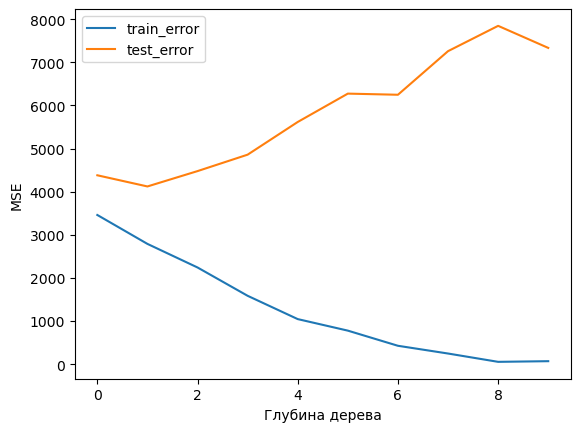

In [9]:
plot_different_max_depths(max_depths=max_depths, n_trees=3)

100%|██████████| 10/10 [00:00<00:00, 29.85it/s]


Количество деревьев в бустинге 10


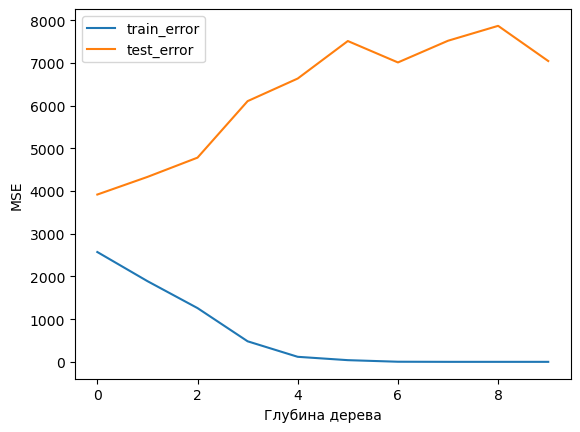

In [10]:
plot_different_max_depths(max_depths=max_depths, n_trees=10)

In [11]:
eta = 1
n_trees = range(1, 50, 1)


def plot_different_num_trees(n_trees=n_trees, max_depth=3):
    train_errors_trees = []
    test_errors_trees = []

    for n in tqdm(n_trees):
        _, train_errors, test_errors = gb_fit(n, max_depth, X_train, X_test, y_train, y_test, eta)
        train_errors_trees.append(train_errors[-1])
        test_errors_trees.append(test_errors[-1])


    print(f'Максимальная глубина дерева {max_depth}')
    plt.plot(n_trees, train_errors_trees, label='train_error')
    plt.plot(n_trees, test_errors_trees, label='test_error')
    plt.xlabel('Количество алгоритмов в бустинге')
    plt.ylabel('MSE')
    plt.xticks(n_trees, n_trees)
    plt.legend()

100%|██████████| 49/49 [00:06<00:00,  7.96it/s]


Максимальная глубина дерева 2


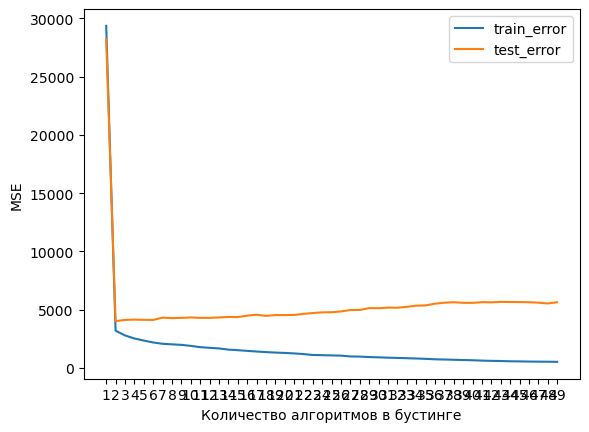

In [12]:
plot_different_num_trees(n_trees=n_trees, max_depth=2)

**2. *Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.**

In [13]:
def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta, sample_coef=0.5):
    n_samples = X_train.shape[0] 
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        indices = np.random.randint(0, n_samples, int(n_samples * sample_coef))
        X_train_sampled, y_train_sampled = X_train[indices], y_train[indices]
        
        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            
            # обучаем первое дерево на случайной половине обучающей выборке            
            tree.fit(X_train_sampled, y_train_sampled)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train_sampled, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train_sampled, residual(y_train_sampled, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [14]:
n_trees = 50
max_depth = 3
eta = 0.3

In [15]:
%%time
_, train_errors_gb, test_errors_gb = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 234 ms


In [16]:
%%time
_, train_errors_sgb, test_errors_sgb = sgb_fit(n_trees, max_depth,
                                               X_train, X_test,
                                               y_train, y_test,
                                               eta, 
                                               sample_coef=0.5
                                              )

Wall time: 230 ms


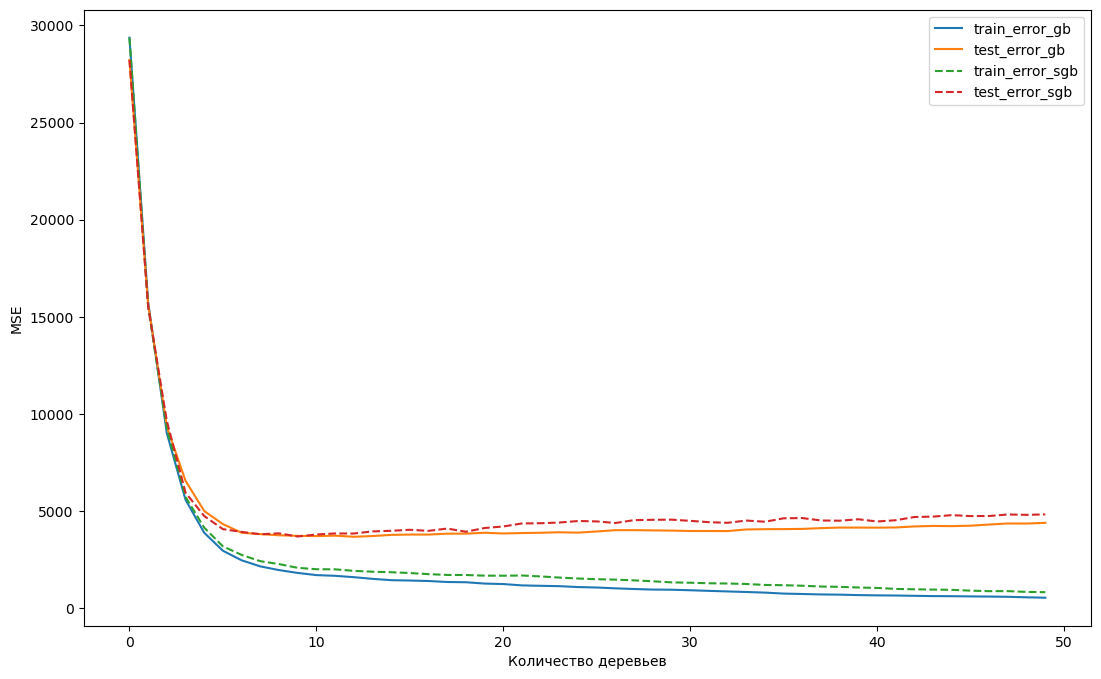

In [17]:
plt.figure(figsize=(13, 8))
plt.plot(range(n_trees), train_errors_gb, label='train_error_gb')
plt.plot(range(n_trees), test_errors_gb, label='test_error_gb')

plt.plot(range(n_trees), train_errors_sgb, label='train_error_sgb', linestyle='--')
plt.plot(range(n_trees), test_errors_sgb, label='test_error_sgb', linestyle='--')
plt.xlabel('Количество деревьев')
plt.ylabel('MSE')
plt.legend()